In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

import PyLasMech as plm

### Read well log datas

In [2]:
LogFiles=plm.FileFinder("../Data/PetrophysicsTVD")

[IO] Found 9 log files


,FileName,Location
0,15_9-F-1 B_TVDlog.las,..\Data\PetrophysicsTVD\15_9-F-1 B_TVDlog.las
1,15_9-F-1 C_TVDlog.las,..\Data\PetrophysicsTVD\15_9-F-1 C_TVDlog.las
2,15_9-F-11 B_TVDlog.las,..\Data\PetrophysicsTVD\15_9-F-11 B_TVDlog.las
3,15_9-F-12_TVDlog.las,..\Data\PetrophysicsTVD\15_9-F-12_TVDlog.las
4,15_9-F-14_TVDlog.las,..\Data\PetrophysicsTVD\15_9-F-14_TVDlog.las
5,15_9-F-15 C_TVDlog.las,..\Data\PetrophysicsTVD\15_9-F-15 C_TVDlog.las
6,15_9-F-15 D_TVDlog.las,..\Data\PetrophysicsTVD\15_9-F-15 D_TVDlog.las
7,15_9-F-4_TVDlog.las,..\Data\PetrophysicsTVD\15_9-F-4_TVDlog.las
8,15_9-F-5_TVDlog.las,..\Data\PetrophysicsTVD\15_9-F-5_TVDlog.las


In [24]:
WellLog=plm.ReadLas(LogFiles[3])
#Print las file summary table
plm.printLas(WellLog)

[IO] Reading F:\Course\PETE 4241\Projects\Data\PetrophysicsTVD\15_9-F-12_TVDlog.las.....
[Warnning] Data size (25898,25899) is in-comptabile with depth/depth_step!
Done!
[LAS Info]
Well Name= 15_9-F-12
Start/Step/End Depth=(239.877600:0.152400:4186.732800)
NULL value= -999.25
Common Depth= (3102.102, 3442.5636)


,Curves,Available Depth (Non-NULL),Raw Min/Max Val,Unit,Comments
0,DEPTH,"[239.8776, 4186.7328]","[239.8776, 4186.7328]",m,Measured Depth
1,CARB_FLAG,"[3102.102, 3519.9828]","[0.0, 1.0]",UNKNOWN,CARB_FLAG:UNKNOWN:rC:NONE:v1
2,COAL_FLAG,"[3102.102, 3505.3524]","[0.0, 0.0]",UNKNOWN,COAL_FLAG:UNKNOWN:rC:NONE:v1
3,DT,"[1368.7044, 3442.5636]","[-68.8278, 161.0148]",us/ft,DT:UNKNOWN:rC:NONE:v2
4,GR,"[240.3348, 4186.7328]","[10.6888, 179.8782]",API,GR:UNKNOWN:rC:NONE:v1
5,NPHI,"[717.6516, 3505.3524]","[0.0282, 1.5057]",v/v_decimal,NPHI:UNKNOWN:rC:NONE:v1
6,RD,"[239.8776, 3505.962]","[0.1, 1319.27404]",UNKNOWN,RD:UNKNOWN:rC:NONE:v1
7,RHOB,"[1349.9592, 3507.486]","[1.3568, 2.9392]",g/cm3,RHOB:UNKNOWN:rC:NONE:v1
8,ROP5_RM,"[239.8776, 3519.3732]","[1.2421, 211.00751]",UNKNOWN,ROP5_RM:UNKNOWN:rC:NONE:v1
9,RS,"[239.8776, 3505.962]","[0.1, 5000.0]",UNKNOWN,RS:UNKNOWN:rC:NONE:v1


### Geomechanical properties calculation

> ##### Parameter and unit setup

In [25]:
#Unit Converter
ft=0.3048 #m
g_cm3=1000 #kg/m3
g=9.8 #m/s2
meter=1
mega=1e6 #Mega
Pa=1 #Pa
us=0.000001 #us, micro seconds
psi=6894.76

#Basic paramters for Volve field
rho_w=1.0*g_cm3  #formation fluid density
rho_m=2.65*g_cm3 #rock matrix density
z_w=80*meter # ocean water depth @ https://www.offshore-technology.com/projects/volve-oil-field-north-sea/
RHOB_avg=1.75*g_cm3 # average bulk density above the reservoir, Z<2576 ft
phi0=0.37
beta=0.0266*(1/mega*Pa) #convert it unit back to Pa


#RHOB DT DTS etc from Log
l=WellLog
param=l.plm_param
GeoMechParams={}


#RHOB DT DTS etc from Log
NonNanIndex=param.getCommonNonNanIndex(l,["RHOB","DT","DTS","TVD"])

DZ=l["TVD"][NonNanIndex]
#Auto unit setup
DZ_unit=param.Units[param.getCurveIndex("TVD")]
if(DZ_unit.lower()=="ft"): DZ=DZ*ft
elif(DZ_unit.lower()=="m"): DZ=DZ*meter
else:print("!!!Unknown Unit!!!!")
    
if("RHOB" in param.CurveNames): 
    RHOB=l["RHOB"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("RHOB")]
    if(unit=="g/cm3"): RHOB=RHOB*g_cm3
    else:print("!!!Unknown Unit!!!!",unit)    
if("DT" in param.CurveNames): 
    DT=l["DT"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("DT")]
    if(unit=="us/ft"): DT=DT*us/ft
    else:print("!!!Unknown Unit!!!!",unit)  
if("DTS" in param.CurveNames): 
    DTS=l["DTS"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("DTS")]
    if(unit=="us/ft"): DTS=DTS*us/ft
    else:print("!!!Unknown Unit!!!!",unit)   

RHOB [Warning] has 207 NAN values in between
DT [Warning] has 532 NAN values in between


> ##### Principle stress & its gradient
$$
S_v=\rho _wgz_w+\bar{\rho}_bg\left( z_0-z_w \right) +\int_{z_0-z_w}^z{\rho _b\left( z \right) gdz}
$$
$$
S_{hmin}=0.84S_v
$$
$$
S_{hmax}=0.89S_v
$$

In [26]:
z_0=DZ[0]

#1. Overburden stress
Sv0=rho_w*g*z_w+RHOB_avg*g*(z_0-z_w)
Sv=[Sv0]+list(Sv0+integrate.cumtrapz(RHOB*g, DZ))
GeoMechParams["Sv"]=np.array(Sv)
GeoMechParams["Sv_grad"]=GeoMechParams["Sv"]/DZ

GeoMechParams["Shmin"]=0.84*GeoMechParams["Sv"]
GeoMechParams["Shmax"]=0.89*GeoMechParams["Sv"]

plm.showTable([DZ/1e3,GeoMechParams["Sv"]/1e6,GeoMechParams["Shmin"]/1e6,GeoMechParams["Shmax"]/1e6],
              ['Depth_GOM(km)','Sv(MPa)','Shmin(MPa)','Shmax(MPa)'],preview=10)

|    |   Depth_GOM(km) |   Sv(MPa) |   Shmin(MPa) |   Shmax(MPa) |
|----|-----------------|-----------|--------------|--------------|
|  0 |         1.3444  |   22.4685 |      18.8735 |      19.9969 |
|  1 |         1.53881 |   26.1425 |      21.9597 |      23.2668 |
|  2 |         1.72939 |   29.7496 |      24.9897 |      26.4772 |
|  3 |         1.91989 |   33.5357 |      28.17   |      29.8468 |
|  4 |         2.12031 |   37.6195 |      31.6004 |      33.4813 |
|  5 |         2.32405 |   41.3757 |      34.7555 |      36.8243 |
|  6 |         2.51895 |   45.2753 |      38.0313 |      40.2951 |
|  7 |         2.68693 |   49.0021 |      41.1618 |      43.6119 |
|  8 |         2.81388 |   51.905  |      43.6002 |      46.1954 |
|  9 |         2.93556 |   54.6672 |      45.9205 |      48.6538 |


> ##### Hydrostatic pressure in MPa.  
The pore pressure can be calculated as follows:  
$${{P}_{p}}={{\bar{\rho }}_{w}}g{z} $$

In [27]:
GeoMechParams["P_pore"]=rho_w*g*DZ

plm.showTable([DZ/1e3,GeoMechParams["P_pore"]/1e6],['Depth_GOM(km)','PorePressure(MPa)'],preview=10)

|    |   Depth_GOM(km) |   PorePressure(MPa) |
|----|-----------------|---------------------|
|  0 |         1.3444  |             13.1751 |
|  1 |         1.53881 |             15.0803 |
|  2 |         1.72939 |             16.948  |
|  3 |         1.91989 |             18.8149 |
|  4 |         2.12031 |             20.779  |
|  5 |         2.32405 |             22.7757 |
|  6 |         2.51895 |             24.6857 |
|  7 |         2.68693 |             26.332  |
|  8 |         2.81388 |             27.576  |
|  9 |         2.93556 |             28.7685 |


> ##### Rock porosity
The rock porosity can be calculated using density log as follows:  
$$
\phi =\frac{\rho _m-\rho _b}{\rho _m-\rho _w}
$$

In [28]:
GeoMechParams["PORO"]=(rho_m-RHOB)/(rho_m-rho_w)

plm.showTable([DZ/1e3,GeoMechParams["PORO"]],['Depth_GOM(km)','Porosity'],preview=10)

|    |   Depth_GOM(km) |   Porosity |
|----|-----------------|------------|
|  0 |         1.3444  |   0.562909 |
|  1 |         1.53881 |   0.388606 |
|  2 |         1.72939 |   0.46103  |
|  3 |         1.91989 |   0.332182 |
|  4 |         2.12031 |   0.373879 |
|  5 |         2.32405 |   0.480606 |
|  6 |         2.51895 |   0.269879 |
|  7 |         2.68693 |   0.240303 |
|  8 |         2.81388 |   0.222667 |
|  9 |         2.93556 |   0.267818 |


> ##### Porosity by Athy's equation  
The effective vertical stress $\sigma'_v$ can be calculated as follows:
$$\sigma'_v=\sigma_v - p_p $$
The porosity can be calculated as follows:
$$\phi=\phi_0 e^{-\beta \sigma'_v} $$

In [29]:
Sv_eff=GeoMechParams["Sv"]-GeoMechParams["P_pore"]
plm.showTable([DZ/1e3,Sv_eff/1e6],['Depth_GOM(km)','Effective Sv(MPa)'],preview=10)

GeoMechParams["PORO_Athy"]=phi0*np.exp(-beta*Sv_eff)
plm.showTable([DZ/1e3,GeoMechParams["PORO_Athy"]],['Depth_GOM(km)','Porosity_Athy'],preview=10)

|    |   Depth_GOM(km) |   Effective Sv(MPa) |
|----|-----------------|---------------------|
|  0 |         1.3444  |             9.29334 |
|  1 |         1.53881 |            11.0622  |
|  2 |         1.72939 |            12.8016  |
|  3 |         1.91989 |            14.7208  |
|  4 |         2.12031 |            16.8404  |
|  5 |         2.32405 |            18.5999  |
|  6 |         2.51895 |            20.5896  |
|  7 |         2.68693 |            22.6702  |
|  8 |         2.81388 |            24.329   |
|  9 |         2.93556 |            25.8988  |
|    |   Depth_GOM(km) |   Porosity_Athy |
|----|-----------------|-----------------|
|  0 |         1.3444  |        0.288963 |
|  1 |         1.53881 |        0.275682 |
|  2 |         1.72939 |        0.263218 |
|  3 |         1.91989 |        0.250117 |
|  4 |         2.12031 |        0.236405 |
|  5 |         2.32405 |        0.225596 |
|  6 |         2.51895 |        0.213966 |
|  7 |         2.68693 |        0.202447 |
|  8 |

> ##### Pore pressure by Athy's equation
The Pore pressure by Athy's can be calculated as follows:  
$$ p_p = \sigma_v +\frac{1}{\beta}\ln{\frac{\phi}{\phi_0}} $$

In [30]:
GeoMechParams["P_pore_Athy"]=GeoMechParams["Sv"]+1/beta*np.log(GeoMechParams["PORO"]/phi0)

plm.showTable([DZ/1e3,GeoMechParams["P_pore_Athy"]/1e6],['Depth_GOM(km)','PorePressure_Athy(MPa)'],preview=10)

|    |   Depth_GOM(km) |   PorePressure_Athy(MPa) |
|----|-----------------|--------------------------|
|  0 |         1.3444  |                  38.2435 |
|  1 |         1.53881 |                  27.987  |
|  2 |         1.72939 |                  38.0188 |
|  3 |         1.91989 |                  29.4823 |
|  4 |         2.12031 |                  38.0115 |
|  5 |         2.32405 |                  51.2082 |
|  6 |         2.51895 |                  33.4133 |
|  7 |         2.68693 |                  32.7765 |
|  8 |         2.81388 |                  32.8137 |
|  9 |         2.93556 |                  42.5171 |


c:\users\binpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [31]:
#Fix inf -inf value in data
for name, data in GeoMechParams.items():
        data[data==-np.inf]=np.nan
        data[data==np.inf]=np.nan
        #GeoMechParams[name]=data

In [32]:
plm.appendCurve(l,'Sv', GeoMechParams["Sv"]/1e6, unit='MPa',descr='PyLasMech overburden stress',dataIndex=NonNanIndex)
plm.appendCurve(l,'Shmin', GeoMechParams["Shmin"]/1e6, unit='MPa',descr='PyLasMech min horizontal stress',dataIndex=NonNanIndex)
plm.appendCurve(l,'Shmax', GeoMechParams["Shmax"]/1e6, unit='MPa',descr='PyLasMech max horizontal stress',dataIndex=NonNanIndex)

plm.appendCurve(l,'PORO', GeoMechParams["PORO"], unit='-',descr='PyLasMech porosity',dataIndex=NonNanIndex)
plm.appendCurve(l,'PORO_Athy', GeoMechParams["PORO_Athy"], unit='-',descr='PyLasMech porosity from Athy',dataIndex=NonNanIndex)
plm.appendCurve(l,'P_pore', GeoMechParams["P_pore"]/1e6, unit='MPa',descr='PyLasMech pore pressure',dataIndex=NonNanIndex)
plm.appendCurve(l,'P_pore_Athy', GeoMechParams["P_pore_Athy"]/1e6, unit='MPa',descr='PyLasMech pore pressure from Athy',dataIndex=NonNanIndex)

Input data size(13609) < DEPTH size (25899), NULL value (nan) will be added
Input data size(13609) < DEPTH size (25899), NULL value (nan) will be added
Input data size(13609) < DEPTH size (25899), NULL value (nan) will be added
Input data size(13609) < DEPTH size (25899), NULL value (nan) will be added
Input data size(13609) < DEPTH size (25899), NULL value (nan) will be added
Input data size(13609) < DEPTH size (25899), NULL value (nan) will be added
Input data size(13609) < DEPTH size (25899), NULL value (nan) will be added


> ##### Shear modulus (G,MPa), Possion ratio and Youngs Modulus (E, MPa) only available for DT/DTS
$$
G=\rho_bV_{s}^{2}
\\
\nu =\frac{V_{p}^{2}-2V_{s}^{2}}{2\left( V_{p}^{2}-V_{s}^{2} \right)}
\\
E=2G\left( 1+\nu \right) 
$$

In [33]:
if("DT" in param.CurveNames and "DTS" in param.CurveNames):
    Vp=1/DT
    Vs=1/DTS

    plm.showTable([DZ/1e3,Vp,Vs],
               ['Depth(km)','$V_p$ (m/s)','$V_s$ (m/s)'])

    GeoMechParams["G"]=RHOB*Vs*Vs
    GeoMechParams["v"]=(Vp**2-2*Vs**2)/2/(Vp**2-Vs**2)
    GeoMechParams["E"]=2*GeoMechParams["G"]*(1+GeoMechParams["v"]) 

    plm.showTable([DZ/1e3,GeoMechParams["G"]/1e9,GeoMechParams["v"],GeoMechParams["E"]/1e9],['Depth(km)','G(GPa)','v','E(GPa)'])

> ##### Unconfined Compressive Strength (UCS)
$$
UCS=e^{-6.36+\text{2.45}\log \left( 0.86V_p-1172 \right)}
$$
When compressive wave velocity is not available the following correlation is used:
$$
UCS=2.922\phi ^{-0.96}
$$


In [40]:
if("DT" in param.CurveNames):
    Vp=1/DT
    GeoMechParams["UCS"]=np.exp(-6.36+2.45*np.log10(0.86*Vp-1172))*mega*Pa
else:
    GeoMechParams["UCS"]=2.922*GeoMechParams["PORO"]**-0.96

plm.showTable([DZ/1e3,GeoMechParams["UCS"]/1e6],['Depth(km)','UCS(MPa)'],preview=10)

|    |   Depth(km) |   UCS(MPa) |
|----|-------------|------------|
|  0 |     1.3444  |    1.40823 |
|  1 |     1.53881 |    1.95676 |
|  2 |     1.72939 |    2.1445  |
|  3 |     1.91989 |    2.17886 |
|  4 |     2.12031 |    3.74815 |
|  5 |     2.32405 |    2.88574 |
|  6 |     2.51895 |    4.85611 |
|  7 |     2.68693 |    7.13196 |
|  8 |     2.81388 |    7.28947 |
|  9 |     2.93556 |    4.6193  |


c:\users\binpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
#Fix inf -inf value in data
for name, data in GeoMechParams.items():
        data[data==-np.inf]=np.nan
        data[data==np.inf]=np.nan
        #GeoMechParams[name]=data

if("DT" in param.CurveNames and "DTS" in param.CurveNames):
    #plm.appendCurve(l,'G', GeoMechParams["G"]/1e9, unit='GPa',descr='PyLasMech Bulk modulus',dataIndex=NonNanIndex)
    plm.appendCurve(l,'v', GeoMechParams["v"], unit='-',descr='PyLasMech possion ratio',dataIndex=NonNanIndex)
    plm.appendCurve(l,'E', GeoMechParams["E"]/1e9, unit='GPa',descr='PyLasMech Youngs modulus',dataIndex=NonNanIndex)
plm.appendCurve(l,'UCS', GeoMechParams["UCS"]/1e6, unit='MPa',descr='PyLasMech UCS',dataIndex=NonNanIndex)

Input data size(13609) < DEPTH size (25899), NULL value (nan) will be added


### Plot and visulization

	Auto Depth Range= (1368.7044, 3442.5636) for  ['PORO', 'PORO_Athy', 'P_pore', 'P_pore_Athy', 'Sv', 'Shmin', 'Shmax', 'UCS']
	 UCS Corrected Min/Max Val [1.1669628604600173, 139.61044176454988]


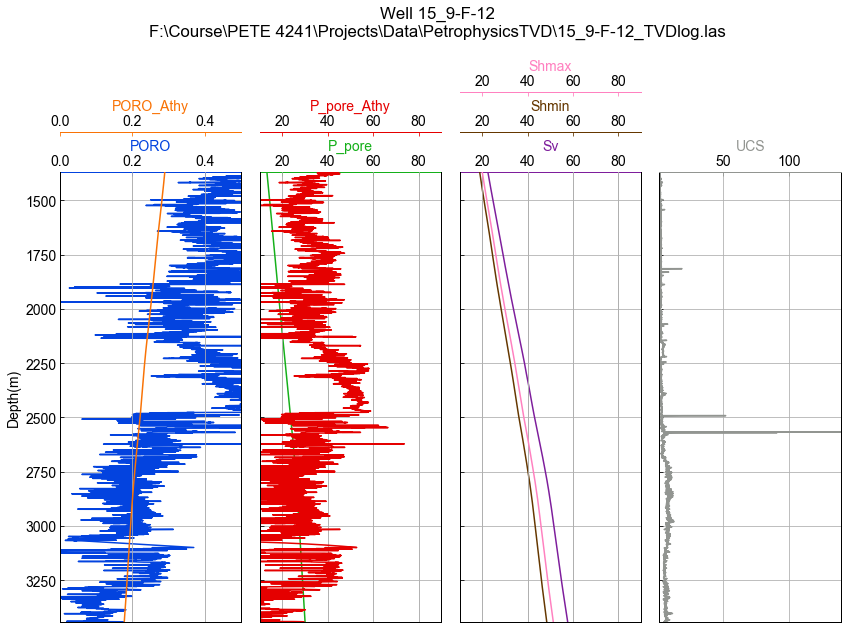

In [45]:
XLims={"P_pore":(10,90),"P_pore_Athy":(10,90),"Sv":(10,90),"Shmax":(10,90),"Shmin":(10,90),"PORO_Athy":(0,0.5),"PORO":(0,0.5)}
PlotNames=plm.utils.sortbyKeyword(GeoMechParams.keys(),"PORO")
fig=plm.plotLogs(LogData=l,CurveNames=PlotNames,XLims=XLims,NumCurvesPattern=[2,2,3,3])

### Export to new las file

In [17]:
fpath="../Data/Petrophysics"#Save all new files at the root of petrophysics
fname=WellLog.plm_param.WellName+"_TVD_Geomech.las"
fname=os.path.join(fpath,fname)
print("[IO] Save new log as ",os.getcwd()+fname)
plm.saveLas(WellLog,fname)

[IO] Save new log as  F:\Course\PETE 4241\Projects\FinalCode../Data/Petrophysics\15_9-F-1 B_TVD_Geomech.las
Write Las file @ ../Data/Petrophysics\15_9-F-1 B_TVD_Geomech.las
